# Derivatives Pricing group project code

In [3]:
import yfinance as yf
# Don't go before 2015, no data in yahoo ! Code will break.
yf.download("BTC-USD", start='2008-01-01')['Adj Close'].index.min()

[*********************100%***********************]  1 of 1 completed


Timestamp('2014-09-17 00:00:00')

## Defining some custom logic

In [4]:
# A class to represent a security traded on a market place
class Stock:
    def __init__(self, ticker, risk_free_interest = 0.05):
        self.ticker = ticker
        self.S = yf.download(ticker, start='2008-01-01')['Adj Close']
        self.risk_free_interest = risk_free_interest # the risk free rate in the market of the stock
        self.sigma = np.sqrt(365) * self.returns().std()  # Assuming 365 trading days in a year

    def prices(self, start="2008-01-01", end=None):
      prices = self.S
      if start:
        prices = prices[prices.index >= start]
      if end:
        prices = prices[prices.index <= end]
      return prices

    def returns(self, start=None, end=None):
      returns = self.S.pct_change().dropna()
      if start:
        returns = returns[returns.index >= start]
      if end:
        returns = returns[returns.index <= end]
      return returns


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm
import yfinance as yf

# a class to represent a european style option on a security
class Option():
  def __init__(self, strike, expiry, stock):
    self.strike = strike
    self.expiry = expiry
    self.stock = stock

  def price(self, S0):
    "the premium of the option. Vectorized for a range of (date, stock)"
    raise NotImplementedError()

  def payoff(self, price_range):
    " the actual payoff at maturity ex: max(K-S,0). Vectorized ..."
    raise NotImplementedError()
  
  def profit(self, price_range):
    " the profit at maturity ex: max(K-S,0) - premium. Vectorized ..."
    raise NotImplementedError()
  
  def deltas(self, price_range):
    " the deltas of the option. Vectorized ..."
    raise NotImplementedError()

  def time_to_expiry(self, series):
    timedelta = pd.to_datetime(self.expiry) - series.index
    seconds_per_year = 365 * 24 * 60 * 60   
    T = timedelta.total_seconds() / seconds_per_year  
    return T

  def d_j(self, j, S, K, r, v, T):
    return (np.log(S/K) + (r + ((-1)**(j-1))*0.5*v*v)*T)/(v*(T**0.5))

  def vanilla_call_price(self, S, K, r, v):
    T = self.time_to_expiry(S)
    return S * norm.cdf(self.d_j(1, S, K, r, v, T)) - K*np.exp(-r*T) * norm.cdf(self.d_j(2, S, K, r, v, T))

  def vanilla_put_price(self, S, K, r, v):
    T = self.time_to_expiry(S)
    return -S * norm.cdf(-self.d_j(1, S, K, r, v, T)) + K*np.exp(-r*T) * norm.cdf(-self.d_j(2, S, K, r, v, T))

  def calculate_option_delta(self, stock, stockprices):
    d1 = self.d_j(1, stockprices, self.strike, stock.risk_free_interest, stock.sigma, self.time_to_expiry(stockprices))
    if self.type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1
    return pd.Series(delta, index=stockprices.index)


class LongCall(Option):
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type="call"
  def price(self, S0):
    return self.vanilla_call_price(S0, self.strike, self.stock.risk_free_interest, self.stock.sigma)
  def payoff(self, S_range):
    return np.maximum(S_range - self.strike, 0) 
  def profit(self, S_range, S0):
    return np.maximum(S_range - self.strike, 0) - self.price(S0)[0]
  def deltas(self, price_range):
    return self.calculate_option_delta(self.stock,  price_range)

class LongPut(Option):
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type="put"
  def price(self, S0):
    return self.vanilla_put_price(S0, self.strike, self.stock.risk_free_interest, self.stock.sigma)
  def payoff(self, S_range):
    return np.maximum(self.strike - S_range, 0)
  def profit(self, S_range, S0):
    return np.maximum(self.strike - S_range, 0) - self.price(S0)[0]
  def deltas(self, price_range):
    return self.calculate_option_delta(self.stock,  price_range)

class ShortCall(Option):
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type="call"
  def price(self, S0):
    return - self.vanilla_call_price(S0, self.strike, self.stock.risk_free_interest, self.stock.sigma)
  def payoff(self, S_range):
    return - np.maximum(S_range - self.strike, 0) 
  def profit(self, S_range, S0):
    return - np.maximum(S_range - self.strike, 0) - self.price(S0)[0]
  def deltas(self, price_range):
    return - self.calculate_option_delta(self.stock,  price_range)

class ShortPut(Option):
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type="put"
  def price(self, S0):
    return - self.vanilla_put_price(S0, self.strike, self.stock.risk_free_interest, self.stock.sigma)
  def payoff(self, S_range):
    return - np.maximum(self.strike - S_range, 0)
  def profit(self, S_range, S0):
    return - np.maximum(self.strike - S_range, 0) - self.price(S0)[0]
  def deltas(self, price_range):
    return - self.calculate_option_delta(self.stock,  price_range)


In [19]:
# a class to represent a strategy that is a collection of options on a security
class Strategy():
  def __init__(self, options):
    self.options = options


  def prices(self, S0):
    "price of the strategy by black and scholes obtain by summing the prices of the underlying options"
    price = np.zeros_like(S0)
    for option in self.options:
      price = np.add(price, option.price(S0))
    return price

  def payoff(self, S_range):
    "payoff of the strategy at maturity (so not counting premium price)"
    pay = np.zeros_like(S_range)
    for option in self.options:
      pay = np.add(pay, option.payoff(S_range))
    return pay

  def profit(self, S_range, S0):
    "profit function of the strategy if you could exercice at the current time"
    pay = np.zeros_like(S_range)
    for option in self.options:
      pay = np.add(pay, option.profit(S_range, S0))
    return pay

  def deltas(self, price_range):
    "delta's obtain by deltha hedging"
    deltas = np.zeros_like(price_range)
    for option in self.options:
      deltas = np.add(deltas, option.deltas(price_range))
    return deltas

  def payoff_plot(self, S_range, S0, title=""):
    "plot of the payoff function of the strategy"
    profit_strategy= self.profit(S_range, S0)
    plt.plot(S_range, profit_strategy, label=title)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Price of bitcoin in dollars')
    plt.ylabel('Profit in dollars')
    if title:
      plt.title(title)
    plt.grid(True, color='gray', linestyle='--', alpha=0.5)

    dy_dx = np.gradient(profit_strategy, S_range)
    non_diff_points = np.where(np.abs(np.diff(np.gradient(profit_strategy))) > 0.5)[0]
    non_diff_points = np.delete(non_diff_points, np.where(np.diff(non_diff_points) == 1))
    plt.plot(S_range[non_diff_points], profit_strategy[non_diff_points], 'ro') 
    for point in non_diff_points:
      plt.text(S_range[point], profit_strategy[point], f"{int(profit_strategy[point])}", ha='center', va='bottom')



## Strategies and their payoff functions

[*********************100%***********************]  1 of 1 completed


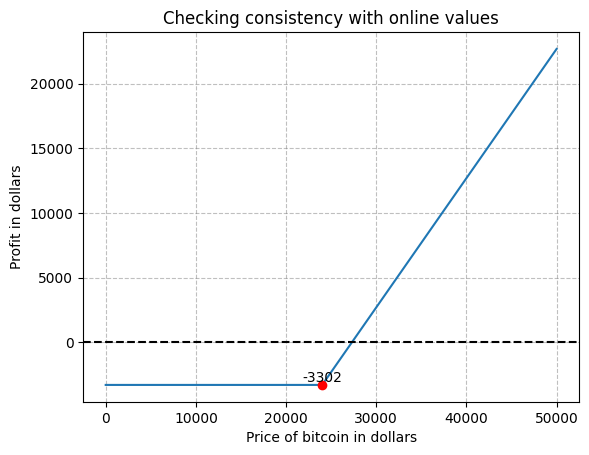

In [20]:
# let's see if our analytical prices correspond +- with CME group's prices online first.

stock = Stock("bTC-USD")

start = pd.to_datetime("2023-06-09")
S0 = stock.prices()[stock.prices().index == start]
expiry = "2023-06-30"
S_range = np.arange(0, 50000, 10)
S_series = pd.Series(S_range, index=pd.date_range(expiry, periods=len(S_range)))

c = Strategy([
    LongCall(strike=24000, expiry=expiry, stock=stock),
   
])
plt.figure()
c.payoff_plot(S_range , S0, "Checking consistency with online values")

# CME group Call option on bitcoin expiring June 2023, computed on 09-01-2023 
# With strike price 24000 has last settle at 2890. We have 3302. 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
the bitcoin price on first june 2023 is  26819.97265625


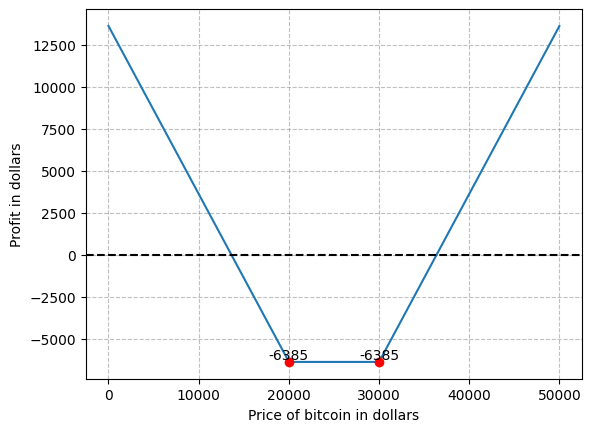

In [23]:
# a quick strangle strategy

stock = Stock("bTC-USD")

expiry="2023-12-01"
start = "2023-06-01"

stock = Stock("BTC-USD")

S0 = stock.prices()[stock.prices().index == pd.to_datetime(start)]
print("the bitcoin price on first june 2023 is ", S0[0])

S_range = np.arange(0, 50000, 10)
S_series = pd.Series(S_range, index=pd.date_range(expiry, periods=len(S_range)))


strangle = Strategy([
    LongPut(strike=20000, expiry=expiry, stock=stock),
    LongCall(strike=30000, expiry=expiry, stock=stock),
])

plt.figure()
strangle.payoff_plot(S_range , S0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
the bitcoin price on first june 2023 is  26819.97265625


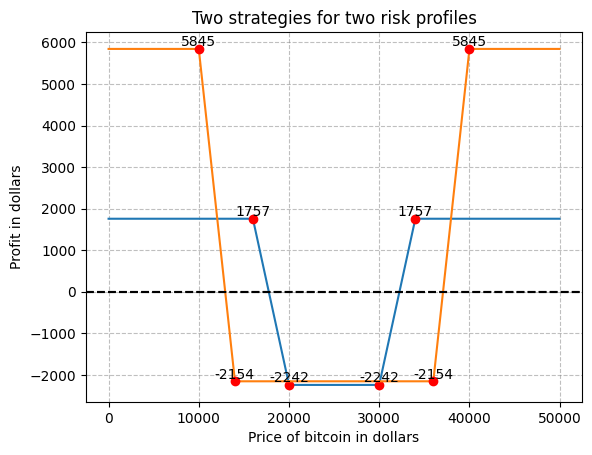

In [21]:
# Let's plot our payoff functions now
stock = Stock("bTC-USD")

expiry="2023-12-01"
start = "2023-06-01"

stock = Stock("BTC-USD")

S0 = stock.prices()[stock.prices().index == pd.to_datetime(start)]
print("the bitcoin price on first june 2023 is ", S0[0])

S_range = np.arange(0, 50000, 10)
S_series = pd.Series(S_range, index=pd.date_range(expiry, periods=len(S_range)))



iron_condor1 = Strategy([
    ShortPut(strike=16000, expiry=expiry, stock=stock),
    LongPut(strike=20000, expiry=expiry, stock=stock),
    LongCall(strike=30000, expiry=expiry, stock=stock),
    ShortCall(strike=34000, expiry=expiry, stock=stock),
])
plt.figure()
iron_condor1.payoff_plot(S_range , S0)


iron_condor2 = Strategy([
    ShortPut(strike=10000, expiry=expiry, stock=stock),
    ShortPut(strike=10000, expiry=expiry, stock=stock),
    LongPut(strike=14000, expiry=expiry, stock=stock),
    LongPut(strike=14000, expiry=expiry, stock=stock),
    LongCall(strike=36000, expiry=expiry, stock=stock),
    LongCall(strike=36000, expiry=expiry, stock=stock),
    ShortCall(strike=40000, expiry=expiry, stock=stock),
    ShortCall(strike=40000, expiry=expiry, stock=stock),
])
iron_condor2.payoff_plot(S_range , S0, "Two strategies for two risk profiles")


## Monte Carlo

In [15]:
import numpy as np

# monte carlo simulation of black-scholes equation for fair pricing
# for speed up, the geometric bronwian is simulated at timesteps of 90 days
class MonteCarlo():
    def __init__(
        self, 
        start,
        end,
        iterations=1000
    ):
        self.iterations = iterations
        self.start = pd.to_datetime(start)
        self.end = pd.to_datetime(end)
        self.days = (self.end-self.start).days

    def scholes(self, price, sigma, r, dt):
        return price * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())

    def simulate_stock_price(self, stock):
        prices = np.zeros(self.days+1)
        prices[0] = stock.prices(self.start, self.start)[0] 
        for i in range(1, self.days + 1):
            prices[i] = self.scholes(prices[i - 1], stock.sigma, stock.risk_free_interest, 1/365)
        return prices

    def price(self, strategy):
        payoffs = np.zeros(self.iterations)
        stock = strategy.options[0].stock
        for i in range(self.iterations):
          if i%100==0:
            print(i)
          prices = self.simulate_stock_price(stock)
          #plt.plot(prices)
          #plt.xlabel('days')
          #plt.ylabel('Price of bitcoin in dollars')
          S_T = prices[-1]
          payoffs[i] = strategy.payoff(pd.Series(S_T, index=[self.end]))
        price = np.exp(-stock.risk_free_interest * self.days/365) * np.mean(payoffs)
        return price



# Create an instance of MonteCarlo and calculate the price of iron_condor1
S0 = stock.prices()[stock.prices().index == pd.to_datetime(start)]
mc = MonteCarlo(iterations=1000, start=start, end=expiry)
price = mc.price(iron_condor1)
print("Price of strategy:", price)

0
100
200
300
400
500
600
700
800
900
Price of strategy: 2252.152616742508


## Replication

In [16]:
# delta heding for replicating the payoff of a strategy of options
def delta_hedging(strategy, start, end):
    "value of the replication portfolio with delta hedging"
    stock = strategy.options[0].stock
    stockprices = stock.prices(start, end)
    deltas = strategy.deltas(stockprices)
    returns = stock.returns(start, end)
    portfolio_value = pd.Series(index=deltas.index)
    portfolio_value.iloc[0] = strategy.prices(stockprices)[0]
    strategy_costs = strategy.prices(stockprices)
    print(f"{deltas.index.min()} - {deltas.index.max()}")
    for i in range(1, len(deltas)):
      stockvalue = (deltas.iloc[i-1] * portfolio_value.iloc[i-1]) * (1+returns.iloc[i])
      cashvalue= ((1 - deltas.iloc[i-1]) * portfolio_value.iloc[i-1]) * (np.exp(stock.risk_free_interest / 365))
      portfolio_value.iloc[i] = stockvalue + cashvalue
    return stockprices, returns, strategy_costs, deltas, portfolio_value

[*********************100%***********************]  1 of 1 completed
2015-01-01 00:00:00 - 2017-02-01 00:00:00


<ipython-input-16-3abef5b3c026>:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_value = pd.Series(index=deltas.index)


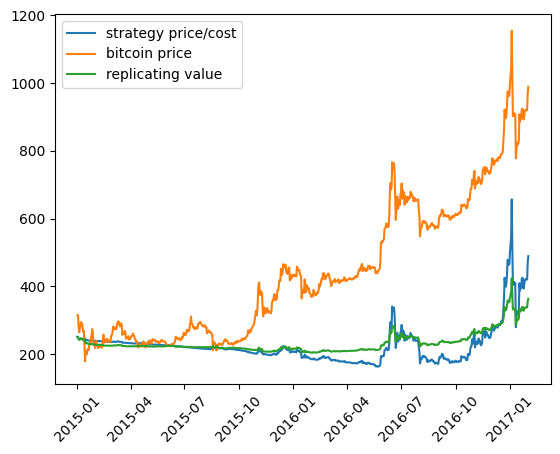

In [17]:
stock = Stock("bTC-USD")

expiry="2017-02-01"

strangle = Strategy([
    LongPut(strike=400, expiry=expiry, stock=stock),
    LongCall(strike=500, expiry=expiry, stock=stock),
])

start="2015-01-01"
end=expiry

stockprices, returns, strategy_costs, deltas, replicated_portfolio = delta_hedging(strangle, start = start, end = end)

plt.figure()
plt.plot(strategy_costs, label='strategy price/cost')
plt.plot(stockprices, label="bitcoin price")
plt.plot(replicated_portfolio, label="replicating value")
plt.legend()
plt.xticks(rotation=45)
plt.show()